## Mixed-Integer Programming (MIP) Optimization
### __[Pyomo Documentation](https://pyomo.readthedocs.io/en/stable/index.html)__


In Pyomo, you can define optimization models as either **ConcreteModel** or **AbstractModel**.

### **ConcreteModel**:

- A ConcreteModel is one where you define the model and its data together.
- When you instantiate a ConcreteModel, you typically provide the actual data for the sets, parameters, variables, constraints, and objective functions at the same time.
- It is useful when you already have all the data available at the time of model creation.
- It is more intuitive for new users or small problems where the data can be easily defined inline.

### **AbstractModel**:

- An AbstractModel, on the other hand, is a blueprint for a model. You define the structure of the model – like the sets, parameters, variables, and constraints – without providing the data.
- The data is provided separately and can be loaded from data files or databases, often using Pyomo's DataPortal.
- It is more flexible and useful when the same model structure will be used for different datasets or when the data is not immediately available at the time of model definition.
- It can be more complex to set up but is powerful for large-scale problems or when automating model runs with different datasets.

## Generate an example network diagram

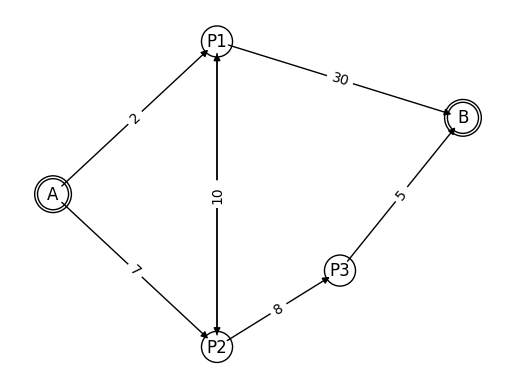

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('A')
G.add_node('B')
G.add_node('P1')
G.add_node('P2')
G.add_node('P3')

# Add edges with weights
G.add_edge('A', 'P1', weight=2)
G.add_edge('A', 'P2', weight=7)
G.add_edge('P1', 'P2', weight=10)
G.add_edge('P2', 'P1', weight=10)
G.add_edge('P1', 'B', weight=30)
G.add_edge('P2', 'P3', weight=8)
G.add_edge('P3', 'B', weight=5)

# Position nodes
pos = {'A': (0, 0), 'P1': (2, 0.02), 'P2': (2, -0.02), 'P3': (3.5, -0.01), 'B': (5, 0.01)}

# Draw all nodes with no color and a distinct node size and node border
nx.draw_networkx_nodes(G, pos, node_color='none', edgecolors='black', node_size=500)

# Highlight the 'A' and 'B' nodes to indicate start and end
nx.draw_networkx_nodes(G, pos, nodelist=['A', 'B'], node_color='none', edgecolors='black', node_size=700)

# Draw the edges
nx.draw_networkx_edges(G, pos)

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw the node labels
node_labels = {node:node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Remove axes
plt.axis('off')
plt.show()

## Our Goal: To construct a path that has the shortest distance.

### Variables, Parameters and Sets

$x_{i,j}$ → Binary decision on connection node i to j

$D_{i,j}$ → Distance from node i to j

$\Omega_{i}^{in}$ → set of nodes that connect to arcs entering node i

$\Omega_{i}^{out}$ → set of nodes that connect to arcs exiting node i

### Objective Function

$$\text{minimize} \quad \sum_{(i,j)} x_{i,j}D_{i,j}$$
- Minimize the distance

### Constraints

$$(1) \sum_{j \in \Omega_{A}^{out}} x_{A,j} = 1$$ 

$$(2) \sum_{i \in \Omega_{B}^{in}} x_{i,B} = 1$$

$$(3) \sum_{j \in \Omega_{i}^{out}} x_{i,j} = \sum_{j \in \Omega_{i}^{in}} x_{j,i} \quad \forall i \neq \{A, B\}$$


- (1) Node $A$ can only goes out to either $P_1$ or $P_2$
- (2) Node $B$ can only be reached by either $P_1$ or $P_3$
- (3) Except for Node $A$ and $B$, the sum of the incoming entries from any node must be equal to the outgoing to form a network.


In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

m = pyo.ConcreteModel()

# Defines a list of all nodes in the network.
m.setAllNodes = ['A','P1','P2','P3','B']

# Defines a list of nodes excluding the start ('A') and end ('B') nodes.
m.setNodes = ['P1','P2','P3']

# Sets of routes from to
m.setRoutes = [['A','P1'],['A','P2'],['P1','P2'],['P2','P1'],['P1','B'],['P2','P3'],['P3','B']]
m.setRoutes_from = {key:[] for key in m.setAllNodes}
m.setRoutes_to = {key:[] for key in m.setAllNodes}
for arc in m.setRoutes:
    m.setRoutes_from[arc[0]].append(arc[1])
    m.setRoutes_to[arc[1]].append(arc[0])

In [3]:
# Check the arcs
print(m.setRoutes_from)
print(m.setRoutes_to)

{'A': ['P1', 'P2'], 'P1': ['P2', 'B'], 'P2': ['P1', 'P3'], 'P3': ['B'], 'B': []}
{'A': [], 'P1': ['A', 'P2'], 'P2': ['A', 'P1'], 'P3': ['P2'], 'B': ['P1', 'P3']}


In [4]:
# Parameters
m.D = {}
m.D['A','P1'] = 2
m.D['A','P2'] = 7
m.D['P1','P2'] = 10
m.D['P2','P1'] = 10
m.D['P1','B'] = 30
m.D['P2','P3'] = 8
m.D['P3','B'] = 5

# Binary Variable 'x'
m.x = pyo.Var(m.setRoutes, within=pyo.Binary)

In [5]:
# Objective function (Minimize the distance)
m.obj = pyo.Objective(expr = sum([
    m.x[route[0], route[1]] * m.D[route[0], route[1]]
    for route in m.setRoutes
    ]), sense=pyo.minimize)

In [6]:
#constraints
m.C1 = pyo.Constraint(expr = sum([m.x['A',j] for j in m.setRoutes_from['A']]) == 1)
m.C2 = pyo.Constraint(expr = sum([m.x[i,'B'] for i in m.setRoutes_to['B']]) == 1)
m.C3 = pyo.ConstraintList()
for i in m.setNodes:
    m.C3.add(sum([m.x[i,j] for j in m.setRoutes_from[i]]) == sum([m.x[j,i] for j in m.setRoutes_to[i]]))

In [7]:
#solve
opt = SolverFactory('glpk', executable='/opt/homebrew/bin/glpsol')
m.results = opt.solve(m)

In [8]:
#print the results
m.pprint()
print('\n\nOF:',pyo.value(m.obj))
for route in m.setRoutes:
    if pyo.value(m.x[route[0], route[1]]) >= 1:
        print('Route activated: %s-%s' % (route[0], route[1]))

2 Set Declarations
    C3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    7 : {('A', 'P1'), ('A', 'P2'), ('P1', 'P2'), ('P2', 'P1'), ('P1', 'B'), ('P2', 'P3'), ('P3', 'B')}

1 Var Declarations
    x : Size=7, Index=x_index
        Key          : Lower : Value : Upper : Fixed : Stale : Domain
         ('A', 'P1') :     0 :   0.0 :     1 : False : False : Binary
         ('A', 'P2') :     0 :   1.0 :     1 : False : False : Binary
         ('P1', 'B') :     0 :   0.0 :     1 : False : False : Binary
        ('P1', 'P2') :     0 :   0.0 :     1 : False : False : Binary
        ('P2', 'P1') :     0 :   0.0 :     1 : False : False : Binary
        ('P2', 'P3') :     0 :   1.0 :     1 : False : False : Binary
         ('P3', 'B') :     0 :   1.0 :     1 : False : Fals

- Comment: With `Pyomo` framework, we got the optimal solution 20.

## Generate a solution diagram

/var/folders/kl/cfztsdns46b6gktb_lbfwn840000gn/T/ipykernel_41041/3265424116.py:38: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=edge_widths)


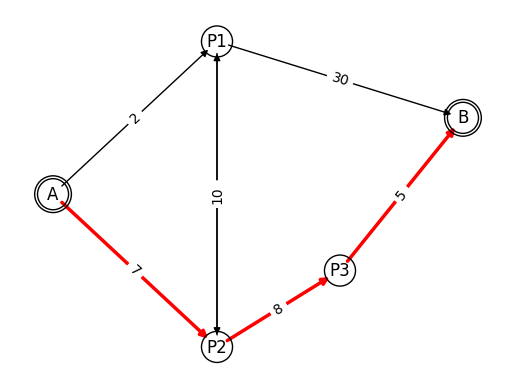

In [9]:
G = nx.DiGraph()

# Define activated routes
activated_routes = [('A', 'P2'), ('P2', 'P3'), ('P3', 'B')]

# Initially add all edges with default properties
edges_with_properties = [
    ('A', 'P1', {'weight': 2, 'color': 'black', 'width': 1}),
    ('A', 'P2', {'weight': 7, 'color': 'black', 'width': 1}),
    ('P1', 'P2', {'weight': 10, 'color': 'black', 'width': 1}),
    ('P2', 'P1', {'weight': 10, 'color': 'black', 'width': 1}),
    ('P1', 'B', {'weight': 30, 'color': 'black', 'width': 1}),
    ('P2', 'P3', {'weight': 8, 'color': 'black', 'width': 1}),
    ('P3', 'B', {'weight': 5, 'color': 'black', 'width': 1}),
]

G.add_edges_from(edges_with_properties)

# Update properties for the activated routes
for route in activated_routes:
    if G.has_edge(*route):
        G[route[0]][route[1]]['color'] = 'red'
        G[route[0]][route[1]]['width'] = 2.5  # Make solution path thicker

# Positions
pos = {'A': (0, 0), 'P1': (2, 0.02), 'P2': (2, -0.02), 'P3': (3.5, -0.01), 'B': (5, 0.01)}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='none', edgecolors='black', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=['A', 'B'], node_color='none', edgecolors='black', node_size=700)

# Separate edgelist for colors and widths
edges = G.edges(data=True)
edge_colors = [data['color'] for _, _, data in edges]
edge_widths = [data['width'] for _, _, data in edges]

# Draw edges with specified colors and widths
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=edge_widths)

# Draw edge labels
edge_labels = {(u, v): data['weight'] for u, v, data in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw node labels
node_labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Remove axes
plt.axis('off')
plt.show()

## Compare with Greedy Heuristic Algorithm

In [10]:
def greedy_heuristic(routes, distances):
    current_point = 'A'
    end_point = 'B'
    path = []
    total_distance = 0

    while current_point != end_point:
        # Filter routes starting from the current point
        available_routes = [r for r in routes if r[0] == current_point]
        # Ensure there are available routes to prevent infinite loop
        if not available_routes:
            raise Exception("No available route to destination.")
            
        # Select the route with the minimum distance not already in the path
        next_route = min(available_routes, key=lambda x: distances[x])
        path.append(next_route)
        total_distance += distances[next_route]  # Accumulate the distance
        current_point = next_route[1]  # Move to the next point

    return path, total_distance

In [11]:
# Define your routes and distances as before
routes = [('A', 'P1'), ('A', 'P2'), ('P1', 'P2'),('P2', 'P1'),('P2', 'P3'),('P1', 'B'),('P3', 'B')]
distances = {('A', 'P1'): 2, ('A', 'P2'): 7, ('P1', 'P2'):10,('P2', 'P1'):10,
             ('P2', 'P3'):8,('P1', 'B'):30,('P3', 'B'):5}

# Select routes using the heuristic
selected_routes, total_distance = greedy_heuristic(routes, distances)
print("Selected Routes:", selected_routes)
print("Total Distance:", total_distance)

Selected Routes: [('A', 'P1'), ('P1', 'P2'), ('P2', 'P3'), ('P3', 'B')]
Total Distance: 25


/var/folders/kl/cfztsdns46b6gktb_lbfwn840000gn/T/ipykernel_41041/728768389.py:37: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=edge_widths)


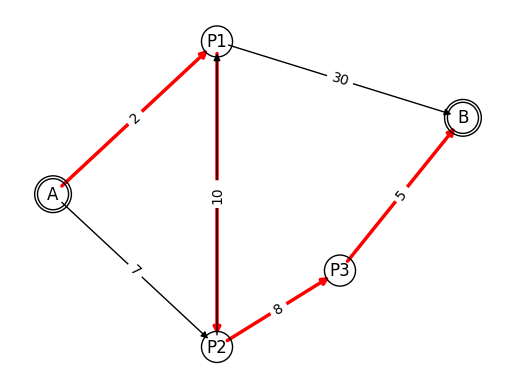

In [12]:
G = nx.DiGraph()

activated_routes = [('A', 'P1'), ('P1', 'P2'), ('P2', 'P3'), ('P3', 'B')]

# Initially add all edges with default properties
edges_with_properties = [
    ('A', 'P1', {'weight': 2, 'color': 'black', 'width': 1}),
    ('A', 'P2', {'weight': 7, 'color': 'black', 'width': 1}),
    ('P1', 'P2', {'weight': 10, 'color': 'black', 'width': 1}),
    ('P2', 'P1', {'weight': 10, 'color': 'black', 'width': 1}),
    ('P1', 'B', {'weight': 30, 'color': 'black', 'width': 1}),
    ('P2', 'P3', {'weight': 8, 'color': 'black', 'width': 1}),
    ('P3', 'B', {'weight': 5, 'color': 'black', 'width': 1}),
]

G.add_edges_from(edges_with_properties)

# Update properties for the activated routes
for route in activated_routes:
    if G.has_edge(*route):
        G[route[0]][route[1]]['color'] = 'red'
        G[route[0]][route[1]]['width'] = 2.5  # Make solution path thicker

# Positions
pos = {'A': (0, 0), 'P1': (2, 0.02), 'P2': (2, -0.02), 'P3': (3.5, -0.01), 'B': (5, 0.01)}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='none', edgecolors='black', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=['A', 'B'], node_color='none', edgecolors='black', node_size=700)

# Separate edgelist for colors and widths
edges = G.edges(data=True)
edge_colors = [data['color'] for _, _, data in edges]
edge_widths = [data['width'] for _, _, data in edges]

# Draw edges with specified colors and widths
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=edge_widths)

# Draw edge labels
edge_labels = {(u, v): data['weight'] for u, v, data in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw node labels
node_labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Remove axes
plt.axis('off')
plt.show()

## Conclusion:
1. With `Pyomo` framework, we got the optimal solution 20.
2. Through `Greedy Heuristic Algorithm`, we got the optimal solution 25, which demonstrates there is no algorithms that always provides the best solution. It depends on the problem statement and objective.